In [40]:
import fnmatch, re, os
import json

def parametrizedFileSelection(fileDirectory, fileArguments):
    files = []
    
    for k,v in fileArgs.items():
        if type(v) is not list:
            fileArgs[k] = [v]
        
    for file in os.listdir(fileDirectory):
        for key in fileArguments:
            match = False
            for value in fileArguments[key]:
                expression = key + "=" + str(value)
                if expression + ',' in file or expression + '_' in file:
                    match = True
            if match == False:
                break
    
        if match == True:
            files.append(file)
        
    return files


# Experiment factors

- filename
- nWorkers
- voterSeed
- comDet
- assignment
- withBoundary (false si order based)
- distType (close/far)
- minDist 

Pour un même nombre de worker on fait varier la seed (cas order based)

In [83]:
import pandas as pd

fileDirectory = "../outputs/facebook_combined_vobws/"

fileArgs = { "nWorkers": 10 }
        
files = parametrizedFileSelection(fileDirectory, fileArgs)

filesData = []

for file in files:
    with open(fileDirectory + file) as json_file:
        data = json.load(json_file)
        filesData.append(data)        
       # print(len(data['candidates'][0]) ,"-", len(data['candidates']), data['candidates'])
df = pd.DataFrame(filesData)

df.head()

,filefullname,filename,filepath,imgDirPath,comDet,imgDiamPath,imgRadPath,imgNpCPath,diameter,diameters,...,imgCDPath,imgInCDPath,imgWpCPath,workerComDistances,workerDistances,workersPerCommunity,distType,minDist,cliqueImgPath,candidates
0,facebook_combined.csv,facebook_combined,graphs/formatted/facebook_combined.csv,graphs/img/facebook_combined/,community_multilevel,graphs/img/facebook_combined/facebook_combined...,graphs/img/facebook_combined/facebook_combined...,graphs/img/facebook_combined/facebook_combined...,8,"[5, 5, 2, 2, 4, 5, 8, 3, 3, 3, 2, 2, 3, 5, 2, 2]",...,graphs/img/facebook_combined/facebook_combined...,graphs/img/facebook_combined/facebook_combined...,graphs/img/facebook_combined/facebook_combined...,"{'0': {'self': [0, 0], 'same': [0, 0], 'other'...","{'self': [0, 10, 0, 0, 0, 0, 0], 'same': [0, 0...",16,close,1,graphs/img/facebook_combined/facebook_combined...,"[[V3952], [V3883], [V3844], [V3459], [V3390], ..."
1,facebook_combined.csv,facebook_combined,graphs/formatted/facebook_combined.csv,graphs/img/facebook_combined/,community_multilevel,graphs/img/facebook_combined/facebook_combined...,graphs/img/facebook_combined/facebook_combined...,graphs/img/facebook_combined/facebook_combined...,8,"[5, 5, 2, 2, 4, 5, 8, 3, 3, 3, 2, 2, 3, 5, 2, 2]",...,graphs/img/facebook_combined/facebook_combined...,graphs/img/facebook_combined/facebook_combined...,graphs/img/facebook_combined/facebook_combined...,"{'0': {'self': [0, 0], 'same': [0, 0], 'other'...","{'self': [0, 10, 0, 0, 0, 0, 0], 'same': [0, 0...",16,close,2,graphs/img/facebook_combined/facebook_combined...,"[[V3844, V3459, V3883, V3952]]"
2,facebook_combined.csv,facebook_combined,graphs/formatted/facebook_combined.csv,graphs/img/facebook_combined/,community_multilevel,graphs/img/facebook_combined/facebook_combined...,graphs/img/facebook_combined/facebook_combined...,graphs/img/facebook_combined/facebook_combined...,8,"[5, 5, 2, 2, 4, 5, 8, 3, 3, 3, 2, 2, 3, 5, 2, 2]",...,graphs/img/facebook_combined/facebook_combined...,graphs/img/facebook_combined/facebook_combined...,graphs/img/facebook_combined/facebook_combined...,"{'0': {'self': [0, 0], 'same': [0, 0], 'other'...","{'self': [0, 10, 0, 0, 0, 0, 0], 'same': [0, 0...",16,close,3,graphs/img/facebook_combined/facebook_combined...,"[[V1286, V3390, V1338, V1516, V2986, V2692]]"
3,facebook_combined.csv,facebook_combined,graphs/formatted/facebook_combined.csv,graphs/img/facebook_combined/,community_multilevel,graphs/img/facebook_combined/facebook_combined...,graphs/img/facebook_combined/facebook_combined...,graphs/img/facebook_combined/facebook_combined...,8,"[5, 5, 2, 2, 4, 5, 8, 3, 3, 3, 2, 2, 3, 5, 2, 2]",...,graphs/img/facebook_combined/facebook_combined...,graphs/img/facebook_combined/facebook_combined...,graphs/img/facebook_combined/facebook_combined...,"{'0': {'self': [0, 0], 'same': [0, 0], 'other'...","{'self': [0, 10, 0, 0, 0, 0, 0], 'same': [0, 0...",16,close,4,graphs/img/facebook_combined/facebook_combined...,"[[V1286, V1338, V1516, V3844, V3459, V3883, V3..."
4,facebook_combined.csv,facebook_combined,graphs/formatted/facebook_combined.csv,graphs/img/facebook_combined/,community_multilevel,graphs/img/facebook_combined/facebook_combined...,graphs/img/facebook_combined/facebook_combined...,graphs/img/facebook_combined/facebook_combined...,8,"[5, 5, 2, 2, 4, 5, 8, 3, 3, 3, 2, 2, 3, 5, 2, 2]",...,graphs/img/facebook_combined/facebook_combined...,graphs/img/facebook_combined/facebook_combined...,graphs/img/facebook_combined/facebook_combined...,"{'0': {'self': [0, 0], 'same': [0, 0], 'other'...","{'self': [0, 10, 0, 0, 0, 0, 0], 'same': [0, 0...",16,far,4,graphs/img/facebook_combined/facebook_combined...,"[[V3952, V3390], [V3952, V2986], [V3952, V2692..."


(array([85., 52.,  5.,  4.,  0.,  1.,  1.,  0.,  1.,  1.]),
 array([ 1. ,  9.9, 18.8, 27.7, 36.6, 45.5, 54.4, 63.3, 72.2, 81.1, 90. ]),
 <BarContainer object of 10 artists>)

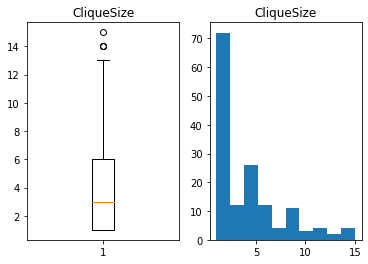

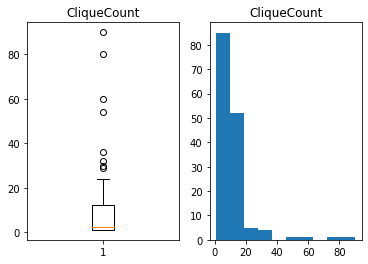

In [84]:
import matplotlib.pyplot as plt

largestCliqueSize = lambda x : len(x[0])
largestCliqueCount = lambda x : len(x)


largestCliqueSizeData = df["candidates"].apply(largestCliqueSize)
largestCliqueCountData = df["candidates"].apply(largestCliqueCount)


fig1, ax1 = plt.subplots(ncols=2)
ax1[0].set_title('CliqueSize')
ax1[0].boxplot(largestCliqueSizeData)
ax1[1].set_title('CliqueSize')
ax1[1].hist(largestCliqueSizeData)

fig2, ax2 = plt.subplots(ncols=2)
ax2[0].set_title('CliqueCount')
ax2[0].boxplot(largestCliqueCountData)
ax2[1].set_title('CliqueCount')
ax2[1].hist(largestCliqueCountData)